### Descripción del proyecto
Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

Crea un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba. 

Además, debes medir la métrica AUC-ROC y compararla con el valor F1.

Descripción de los datos
Puedes encontrar los datos en el archivo  /datasets/Churn.csv file. Descarga el conjunto de datos.

Características

* RowNumber: índice de cadena de datos
* CustomerId: identificador de cliente único
* Surname: apellido
* CreditScore: valor de crédito
* Geography: país de residencia
* Gender: sexo
* Age: edad
* Tenure: período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)
* Balance: saldo de la cuenta
* NumOfProducts: número de productos bancarios utilizados por el cliente
* HasCrCard: el cliente tiene una tarjeta de crédito (1 - sí; 0 - no)
* IsActiveMember: actividad del cliente (1 - sí; 0 - no)
* EstimatedSalary: salario estimado

Objetivo

Exited: El cliente se ha ido (1 - sí; 0 - no)

In [1]:
# Bibliotecas estándar de Python
import os
import sys
import numpy as np
import pandas as pd

# Bibliotecas de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    roc_auc_score,
    f1_score,
    confusion_matrix
)
from sklearn.utils import shuffle
import missingno as mnso


# Técnicas de sobremuestreo y submuestreo
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours


#### Preprocesamiento de datos

In [2]:
# Agregamos el archivo util_functions.py   //archivo personal con funciones utiles//
module_path = os.path.abspath(os.path.join('..', 'functions_RoCCO'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

# Importa la función missing_case_summary
from util_functions import *

In [3]:
raw_data = pd.read_csv('../raw/Churn.csv') #carga de datos
raw_data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [4]:
#revisamos los datos
raw_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


<Figure size 1000x600 with 0 Axes>

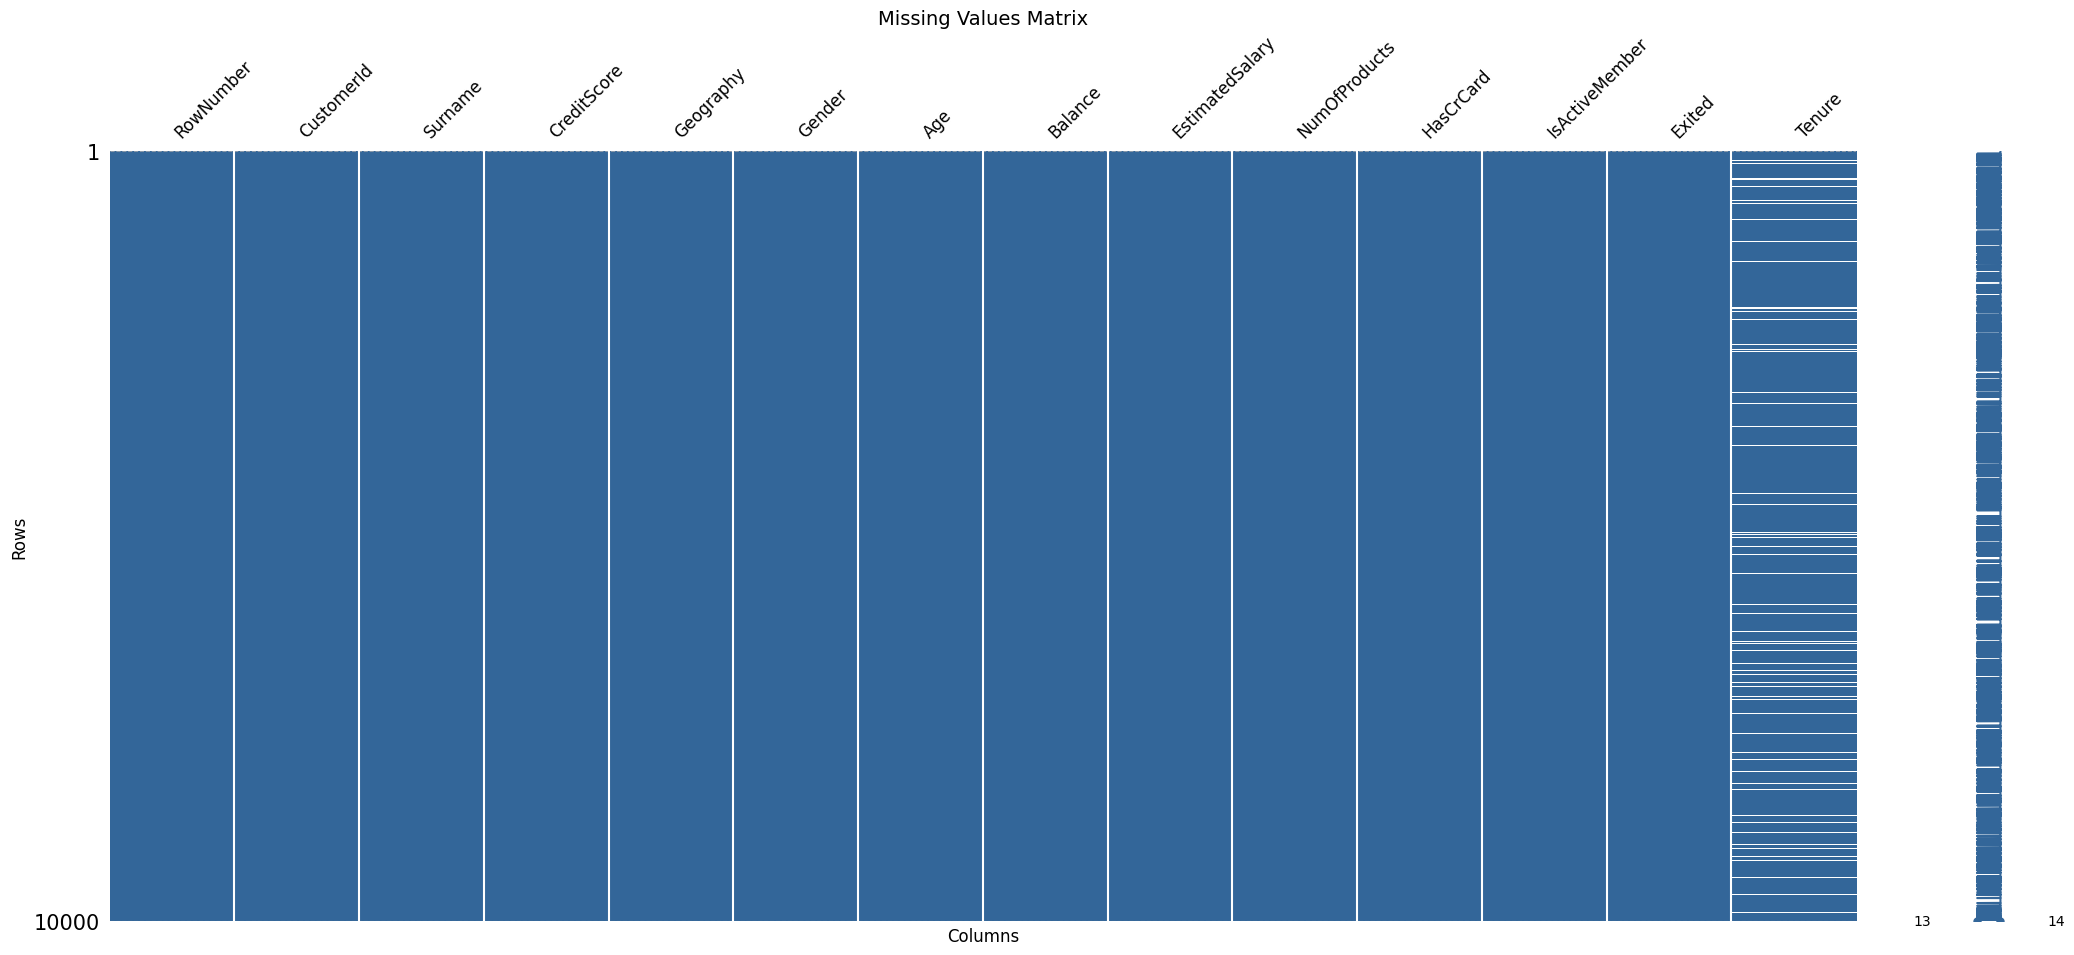

In [5]:
plot_missing_values_matrix(raw_data)

In [6]:
raw_data.duplicated().value_counts()

False    10000
Name: count, dtype: int64

In [7]:
raw_data[raw_data.select_dtypes('object').columns]=raw_data[raw_data.select_dtypes('object').columns].astype('category')
raw_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   RowNumber        10000 non-null  int64   
 1   CustomerId       10000 non-null  int64   
 2   Surname          10000 non-null  category
 3   CreditScore      10000 non-null  int64   
 4   Geography        10000 non-null  category
 5   Gender           10000 non-null  category
 6   Age              10000 non-null  int64   
 7   Tenure           9091 non-null   float64 
 8   Balance          10000 non-null  float64 
 9   NumOfProducts    10000 non-null  int64   
 10  HasCrCard        10000 non-null  int64   
 11  IsActiveMember   10000 non-null  int64   
 12  EstimatedSalary  10000 non-null  float64 
 13  Exited           10000 non-null  int64   
dtypes: category(3), float64(3), int64(8)
memory usage: 986.3 KB


In [8]:
# Porcentaje de Faltantes y no faltantes
missing_data_by_column(raw_data)

,variable,n_missing,n_cases,complete_cases,pct_missing
7,Tenure,909,10000,9091,9.09
0,RowNumber,0,10000,10000,0.00
2,Surname,0,10000,10000,0.00
3,CreditScore,0,10000,10000,0.00
4,Geography,0,10000,10000,0.00
1,CustomerId,0,10000,10000,0.00
5,Gender,0,10000,10000,0.00
6,Age,0,10000,10000,0.00
8,Balance,0,10000,10000,0.00
9,NumOfProducts,0,10000,10000,0.00


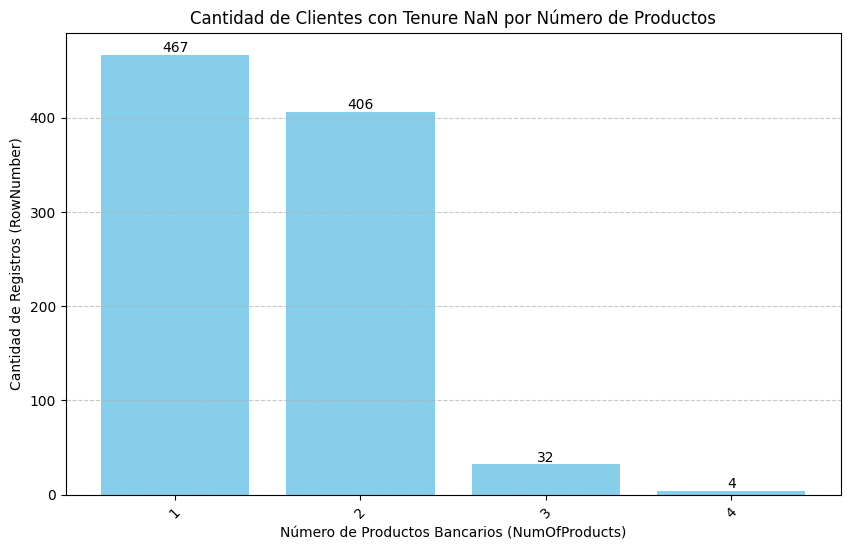

In [9]:

# Calcular la cantidad de registros con Tenure NaN, agrupados por NumOfProducts
result = raw_data[raw_data['Tenure'].isna()].groupby('NumOfProducts')['RowNumber'].count()

# Convertir el índice a string para mejorar la visualización (opcional)
result.index = result.index.astype(str)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(result.index, result.values, color='skyblue')

# Agregar etiquetas de valor encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom')

plt.xlabel('Número de Productos Bancarios (NumOfProducts)')
plt.ylabel('Cantidad de Registros (RowNumber)')
plt.title('Cantidad de Clientes con Tenure NaN por Número de Productos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


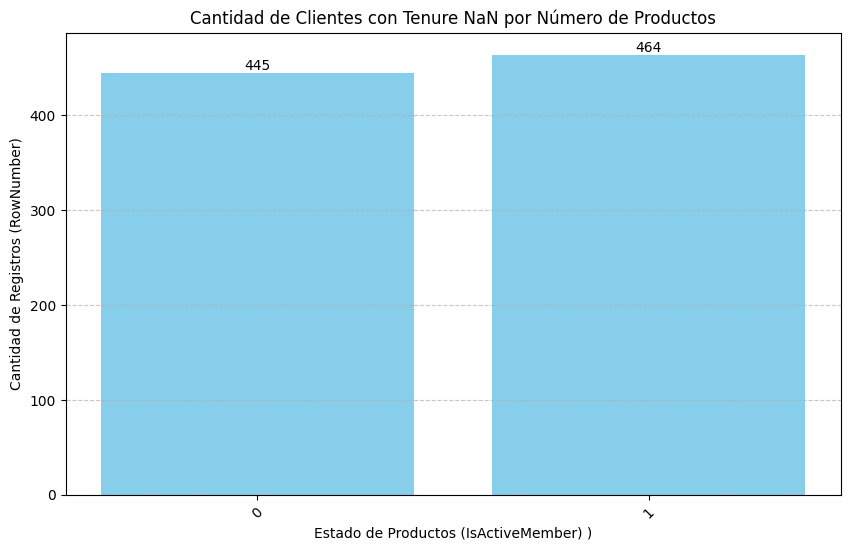

In [10]:
# Calcular la cantidad de registros con Tenure NaN, agrupados por NumOfProducts
result = raw_data[raw_data['Tenure'].isna()].groupby('IsActiveMember')['RowNumber'].count()

# Convertir el índice a string para mejorar la visualización (opcional)
result.index = result.index.astype(str)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(result.index, result.values, color='skyblue')

# Agregar etiquetas de valor encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom')

plt.xlabel('Estado de Productos (IsActiveMember) )')
plt.ylabel('Cantidad de Registros (RowNumber)')
plt.title('Cantidad de Clientes con Tenure NaN por Número de Productos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


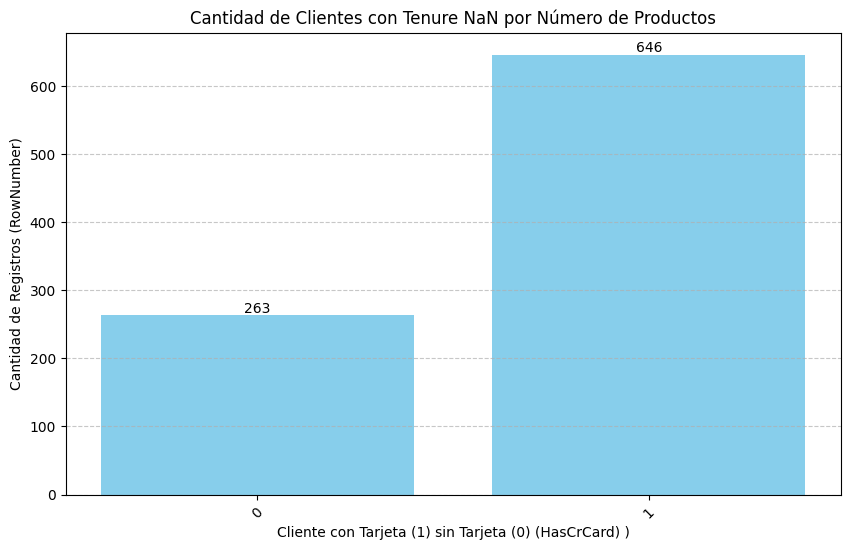

In [11]:
# Calcular la cantidad de registros con Tenure NaN, agrupados por NumOfProducts
result = raw_data[raw_data['Tenure'].isna()].groupby('HasCrCard')['RowNumber'].count()

# Convertir el índice a string para mejorar la visualización (opcional)
result.index = result.index.astype(str)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(result.index, result.values, color='skyblue')

# Agregar etiquetas de valor encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom')

plt.xlabel('Cliente con Tarjeta (1) sin Tarjeta (0) (HasCrCard) )')
plt.ylabel('Cantidad de Registros (RowNumber)')
plt.title('Cantidad de Clientes con Tenure NaN por Número de Productos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [12]:
# Imputacion de datos, con mediana
raw_data['Tenure'] = raw_data['Tenure'].fillna(raw_data['Tenure'].median())
raw_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   RowNumber        10000 non-null  int64   
 1   CustomerId       10000 non-null  int64   
 2   Surname          10000 non-null  category
 3   CreditScore      10000 non-null  int64   
 4   Geography        10000 non-null  category
 5   Gender           10000 non-null  category
 6   Age              10000 non-null  int64   
 7   Tenure           10000 non-null  float64 
 8   Balance          10000 non-null  float64 
 9   NumOfProducts    10000 non-null  int64   
 10  HasCrCard        10000 non-null  int64   
 11  IsActiveMember   10000 non-null  int64   
 12  EstimatedSalary  10000 non-null  float64 
 13  Exited           10000 non-null  int64   
dtypes: category(3), float64(3), int64(8)
memory usage: 986.3 KB


In [13]:
df_bank =raw_data.copy(deep=True) #copiamos la data a df_bank
df_bank =  pd.get_dummies(df_bank, drop_first=True) 
df_bank[df_bank.select_dtypes('bool').columns] = df_bank[df_bank.select_dtypes('bool').columns].astype(int)
df_bank

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_Zotova,Surname_Zox,Surname_Zubarev,Surname_Zubareva,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,619,42,2.0,0.00,1,1,1,101348.88,...,0,0,0,0,0,0,0,0,0,0
1,2,15647311,608,41,1.0,83807.86,1,0,1,112542.58,...,0,0,0,0,0,0,0,0,1,0
2,3,15619304,502,42,8.0,159660.80,3,1,0,113931.57,...,0,0,0,0,0,0,0,0,0,0
3,4,15701354,699,39,1.0,0.00,2,0,0,93826.63,...,0,0,0,0,0,0,0,0,0,0
4,5,15737888,850,43,2.0,125510.82,1,1,1,79084.10,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,771,39,5.0,0.00,2,1,0,96270.64,...,0,0,0,0,0,0,0,0,0,1
9996,9997,15569892,516,35,10.0,57369.61,1,1,1,101699.77,...,0,0,0,0,0,0,0,0,0,1
9997,9998,15584532,709,36,7.0,0.00,1,0,1,42085.58,...,0,0,0,0,0,0,0,0,0,0
9998,9999,15682355,772,42,3.0,75075.31,2,1,0,92888.52,...,0,0,0,0,0,0,0,1,0,1


#### Examina el equilibrio de clases. Entrena el modelo sin tener en cuenta el desequilibrio.

In [14]:
#Dividimos los datos entre caracteristicas y target
target = df_bank['Exited']
features = df_bank.drop('Exited',axis=1)

Exited
0    7963
1    2037
Name: count, dtype: int64


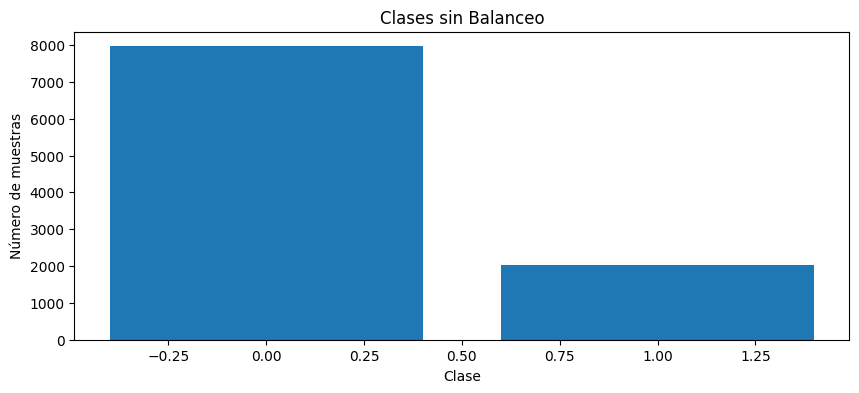

In [33]:
# Revisamos cuantos datos tiene cada clase.
print(target.value_counts()) # vemo que hay un desequilibrio entre clase 1 y clase 0 de 4 a 1 (4:1)

#Visualización de la distribución
plt.figure(figsize=(10,4))
plt.bar([0,1],np.bincount(target))
plt.title("Clases sin Balanceo")
plt.xlabel("Clase")
plt.ylabel("Número de muestras")
plt.show()

In [16]:
# Dividimos los datos para entrenamiento y validacion.
features_train, features_valid, target_train,target_valid = train_test_split(features, target, random_state=42)

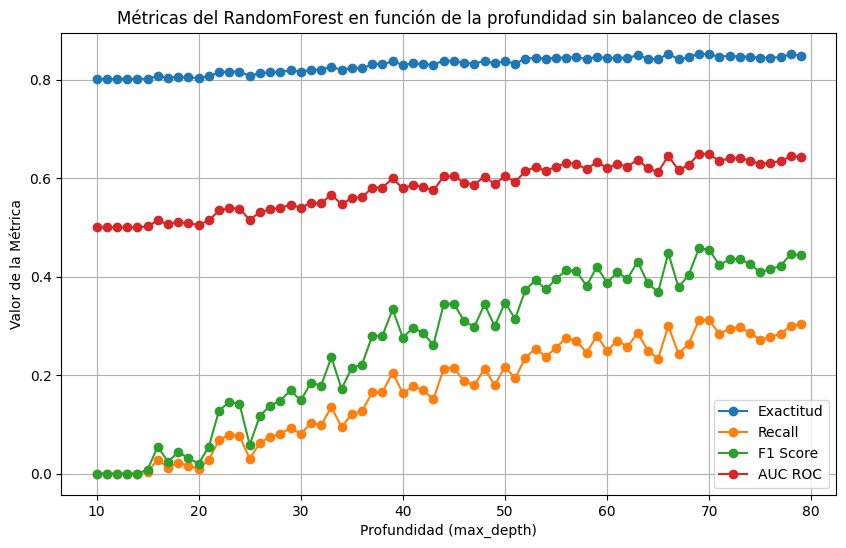

In [17]:
# Asegúrate de tener definidos features_train, target_train, features_valid y target_valid

# Inicializar listas para almacenar las métricas y los valores de profundidad
depths = []
accuracies = []
recalls = []
f1_scores = []
auc_rocs = []

# Iterar sobre diferentes valores de max_depth
for depth in range(10, 80):
    # Crear y entrenar el modelo
    model = RandomForestClassifier(random_state=42, n_estimators=20, max_depth=depth)
    model.fit(features_train, target_train)
    
    # Realizar predicciones sobre el conjunto de validación
    predicted = model.predict(features_valid)
    
    # Calcular las métricas
    acc = accuracy_score(target_valid, predicted)
    rec = recall_score(target_valid, predicted)
    f1 = f1_score(target_valid, predicted)
    auc = roc_auc_score(target_valid, predicted)
    
    # Almacenar los resultados
    depths.append(depth)
    accuracies.append(acc)
    recalls.append(rec)
    f1_scores.append(f1)
    auc_rocs.append(auc)

# Crear una figura para graficar las métricas
plt.figure(figsize=(10, 6))
plt.plot(depths, accuracies, marker='o', label='Exactitud')
plt.plot(depths, recalls, marker='o', label='Recall')
plt.plot(depths, f1_scores, marker='o', label='F1 Score')
plt.plot(depths, auc_rocs, marker='o', label='AUC ROC')

# Personalizar el gráfico
plt.xlabel('Profundidad (max_depth)')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas del RandomForest en función de la profundidad sin balanceo de clases')
plt.legend()
plt.grid(True)
plt.show()


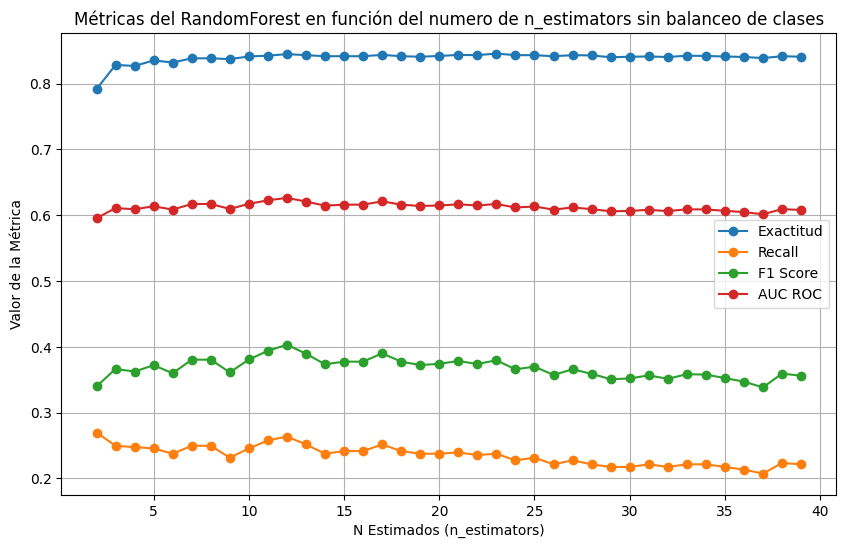

In [18]:
# Asegúrate de tener definidos features_train, target_train, features_valid y target_valid

# Inicializar listas para almacenar las métricas y los valores de profundidad
n_estimators = []
accuracies = []
recalls = []
f1_scores = []
auc_rocs = []

# Iterar sobre diferentes valores de max_depth
for n_estimate in range(2, 40):
    # Crear y entrenar el modelo
    model = RandomForestClassifier(random_state=42, n_estimators=n_estimate, max_depth=54)
    model.fit(features_train, target_train)
    
    # Realizar predicciones sobre el conjunto de validación
    predicted = model.predict(features_valid)
    
    # Calcular las métricas
    acc = accuracy_score(target_valid, predicted)
    rec = recall_score(target_valid, predicted)
    f1 = f1_score(target_valid, predicted)
    auc = roc_auc_score(target_valid, predicted)
    
    # Almacenar los resultados
    n_estimators.append(n_estimate)
    accuracies.append(acc)
    recalls.append(rec)
    f1_scores.append(f1)
    auc_rocs.append(auc)

# Crear una figura para graficar las métricas
plt.figure(figsize=(10, 6))
plt.plot(n_estimators, accuracies, marker='o', label='Exactitud')
plt.plot(n_estimators, recalls, marker='o', label='Recall')
plt.plot(n_estimators, f1_scores, marker='o', label='F1 Score')
plt.plot(n_estimators, auc_rocs, marker='o', label='AUC ROC')

# Personalizar el gráfico
plt.xlabel('N Estimados (n_estimators)')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas del RandomForest en función del numero de n_estimators sin balanceo de clases')
plt.legend()
plt.grid(True)
plt.show()


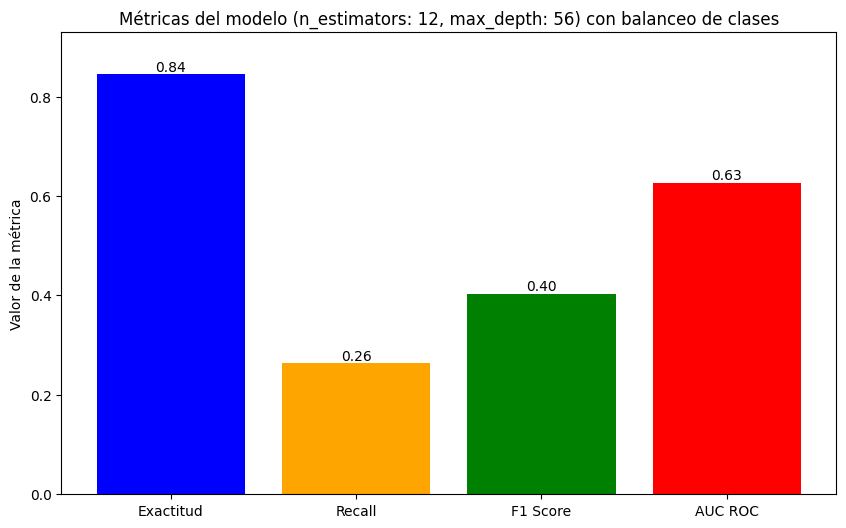

In [49]:
# Modelo ajustado
n = 12
d = 56
model = RandomForestClassifier(random_state=42, n_estimators=n, max_depth=54)
model.fit(features_train,target_train)
predicted = model.predict(features_valid)

# Calcular las métricas
acc = accuracy_score(target_valid, predicted)
rec = recall_score(target_valid, predicted)
f1 = f1_score(target_valid, predicted)
auc = roc_auc_score(target_valid, predicted)

# Preparar los datos para la gráfica
metricas = {
    'Exactitud': acc,
    'Recall': rec,
    'F1 Score': f1,
    'AUC ROC': auc
}
nombres = list(metricas.keys())
valores = list(metricas.values())

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
barras = plt.bar(nombres, valores, color=['blue', 'orange', 'green', 'red'])

# Agregar el valor exacto de cada métrica encima de la barra correspondiente
for barra in barras:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, altura, f'{altura:.2f}', ha='center', va='bottom')

plt.title(f'Métricas del modelo (n_estimators: {n}, max_depth: {d}) con balanceo de clases')
plt.ylabel('Valor de la métrica')
plt.ylim(0, 1.1 * max(valores))  # Ajustar límite superior para dar espacio a las etiquetas
plt.show()

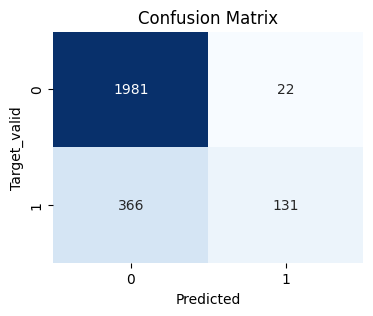

In [20]:
# Matrix de Confusion
cm = confusion_matrix(target_valid,predicted)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Target_valid')
plt.title('Confusion Matrix')
plt.show()

 Hallazgos:
 
- Como podemos ver las metricas nos indican que el modelo es lo suficiente bueno, sobre todo por F1_score y recall como explico a continuacion.
- Como vemos en la matrix de confusion tenemos verdaderos positivos, pero muchos mas verdaderos negativos.
- Para Exactitud o Accuracy, tenemos que estamos detectando el 84% de los valores positivos, este parametro es bueno.
- Para recall o sensibilidad, tenemos que solo el 26% son verdaderos positivos, es decir solo este porcentaje fueron identificados correctamente.
- F1_score, es 40% nos indica probablemente un desbalance ya que exactitud y/o recall tiene problemas.
- Auc_Roc, tenemos un 63%, esto nos indica que apenas y es algo mejor que un modelo al azar.

#### Mejora la calidad del modelo. Asegúrate de utilizar al menos dos enfoques para corregir el desequilibrio de clases. Utiliza conjuntos de entrenamiento y validación para encontrar el mejor modelo y el mejor conjunto de parámetros. Entrena diferentes modelos en los conjuntos de entrenamiento y validación. Encuentra el mejor. 



In [ ]:
#Tenemos 2 opciones para ajustar el desequilibrio de clases el sobremuestreo o submuestreo, escogere el sobremuestreo ya que el submuestreo elimina datos y no lo considero la mejor opcion
target.value_counts() 

Exited
0    7963
1    2037
Name: count, dtype: int64

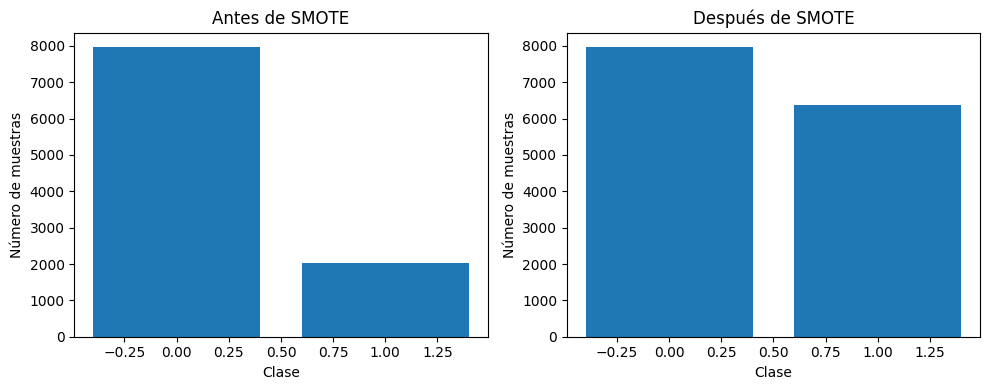

Distribución de clases después del balanceo:
Exited
0    7963
1    6370
Name: count, dtype: int64


In [22]:
# Estrategia de sobremuestreo: 
# Se usará SMOTE para aumentar la clase minoritaria
smote = SMOTE(sampling_strategy=0.8, random_state=42)
features_smote, target_smote = smote.fit_resample(features, target)

# Visualización de la distribución
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar([0, 1], np.bincount(target))
plt.title("Antes de SMOTE")
plt.xlabel("Clase")
plt.ylabel("Número de muestras")

plt.subplot(1,2,2)
plt.bar([0, 1], np.bincount(target_smote))
plt.title("Después de SMOTE")
plt.xlabel("Clase")
plt.ylabel("Número de muestras")
plt.tight_layout()
plt.show()

# Verificar la distribución de clases después del balanceo
print("Distribución de clases después del balanceo:")
print(pd.Series(target_smote).value_counts())

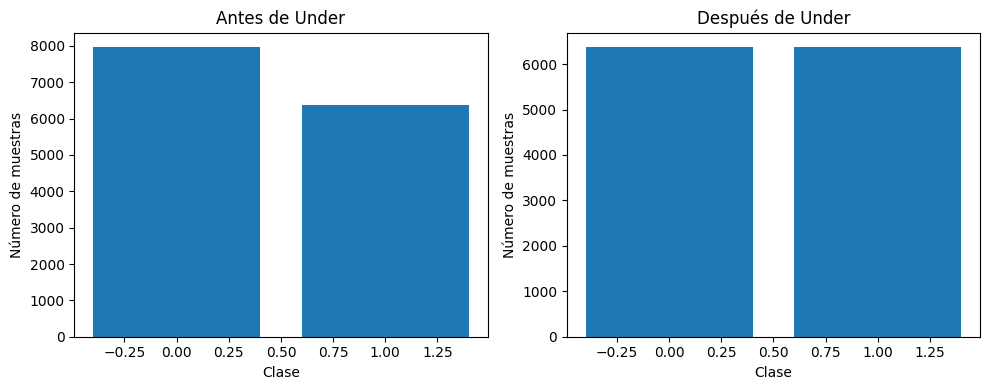

Distribución de clases después del balanceo:
Exited
0    6370
1    6370
Name: count, dtype: int64


In [23]:
# Estrategia de sobremuestreo: 
# Se usará RandomUnder para disminuir la clase mayoritaria.
under = RandomUnderSampler(sampling_strategy=1, random_state=42)
features_balanced, target_balanced = under.fit_resample(features_smote, target_smote)

# Opcional: Visualización de la distribución
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar([0, 1], np.bincount(target_smote))
plt.title("Antes de Under")
plt.xlabel("Clase")
plt.ylabel("Número de muestras")

plt.subplot(1,2,2)
plt.bar([0, 1], np.bincount(target_balanced))
plt.title("Después de Under")
plt.xlabel("Clase")
plt.ylabel("Número de muestras")
plt.tight_layout()
plt.show()

# Verificar la distribución de clases después del balanceo
print("Distribución de clases después del balanceo:")
print(pd.Series(target_balanced).value_counts())

In [24]:
#Realizamos una mezcla de los datos para evitar sesgos
features_resampled, target_resampled = shuffle(features_balanced, target_balanced, random_state=42)

In [25]:
# Obtenemos nuevamente los datos de entrenamiento del modelo
features_train_res, features_valid_res, target_train_res, target_valid_res = train_test_split(features_resampled, target_resampled, random_state=42)

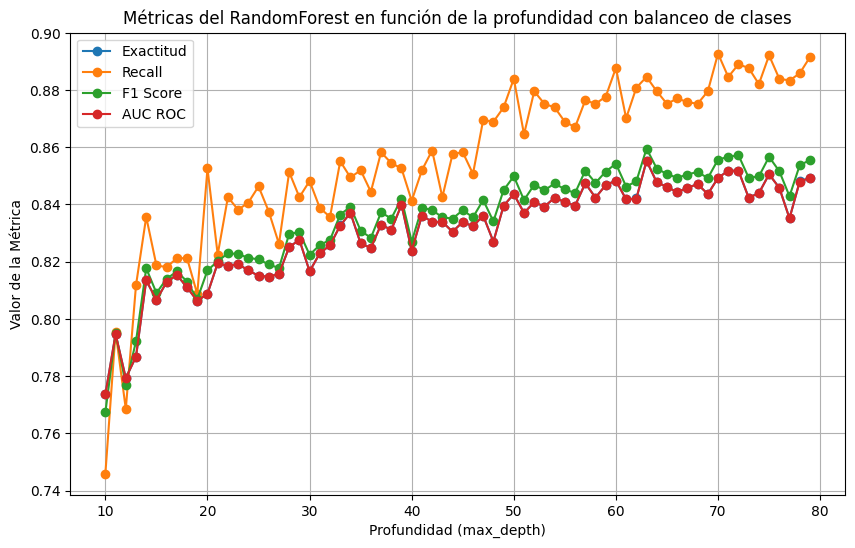

In [26]:
# Asegúrate de tener definidos features_train, target_train, features_valid y target_valid

# Inicializar listas para almacenar las métricas y los valores de profundidad
depths = []
accuracies = []
recalls = []
f1_scores = []
auc_rocs = []

# Iterar sobre diferentes valores de max_depth
for depth in range(10, 80):
    # Crear y entrenar el modelo
    model = RandomForestClassifier(random_state=42, n_estimators=20, max_depth=depth)
    model.fit(features_train_res, target_train_res)
    
    # Realizar predicciones sobre el conjunto de validación
    predicted = model.predict(features_valid_res)
    
    # Calcular las métricas
    acc = accuracy_score(target_valid_res, predicted)
    rec = recall_score(target_valid_res, predicted)
    f1 = f1_score(target_valid_res, predicted)
    auc = roc_auc_score(target_valid_res, predicted)
    
    # Almacenar los resultados
    depths.append(depth)
    accuracies.append(acc)
    recalls.append(rec)
    f1_scores.append(f1)
    auc_rocs.append(auc)

# Crear una figura para graficar las métricas
plt.figure(figsize=(10, 6))
plt.plot(depths, accuracies, marker='o', label='Exactitud')
plt.plot(depths, recalls, marker='o', label='Recall')
plt.plot(depths, f1_scores, marker='o', label='F1 Score')
plt.plot(depths, auc_rocs, marker='o', label='AUC ROC')

# Personalizar el gráfico
plt.xlabel('Profundidad (max_depth)')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas del RandomForest en función de la profundidad con balanceo de clases')
plt.legend()
plt.grid(True)
plt.show()


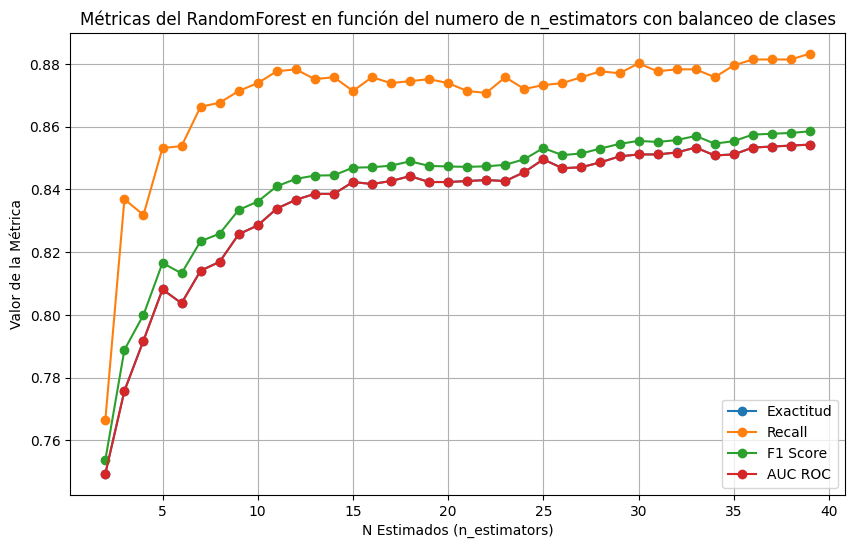

In [32]:
# Asegúrate de tener definidos features_train, target_train, features_valid y target_valid

# Inicializar listas para almacenar las métricas y los valores de profundidad
n_estimators = []
accuracies = []
recalls = []
f1_scores = []
auc_rocs = []

# Iterar sobre diferentes valores de max_depth
for n_estimate in range(2, 40):
    # Crear y entrenar el modelo
    model = RandomForestClassifier(random_state=42, n_estimators=n_estimate, max_depth=54)
    model.fit(features_train_res, target_train_res)
    
    # Realizar predicciones sobre el conjunto de validación
    predicted_res = model.predict(features_valid_res)
    
    # Calcular las métricas
    acc = accuracy_score(target_valid_res, predicted_res)
    rec = recall_score(target_valid_res, predicted_res)
    f1 = f1_score(target_valid_res, predicted_res)
    auc = roc_auc_score(target_valid_res, predicted_res)
    
    # Almacenar los resultados
    n_estimators.append(n_estimate)
    accuracies.append(acc)
    recalls.append(rec)
    f1_scores.append(f1)
    auc_rocs.append(auc)

# Crear una figura para graficar las métricas
plt.figure(figsize=(10, 6))
plt.plot(n_estimators, accuracies, marker='o', label='Exactitud')
plt.plot(n_estimators, recalls, marker='o', label='Recall')
plt.plot(n_estimators, f1_scores, marker='o', label='F1 Score')
plt.plot(n_estimators, auc_rocs, marker='o', label='AUC ROC')

# Personalizar el gráfico
plt.xlabel('N Estimados (n_estimators)')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas del RandomForest en función del numero de n_estimators con balanceo de clases')
plt.legend()
plt.grid(True)
plt.show()


#### Realiza la prueba final.

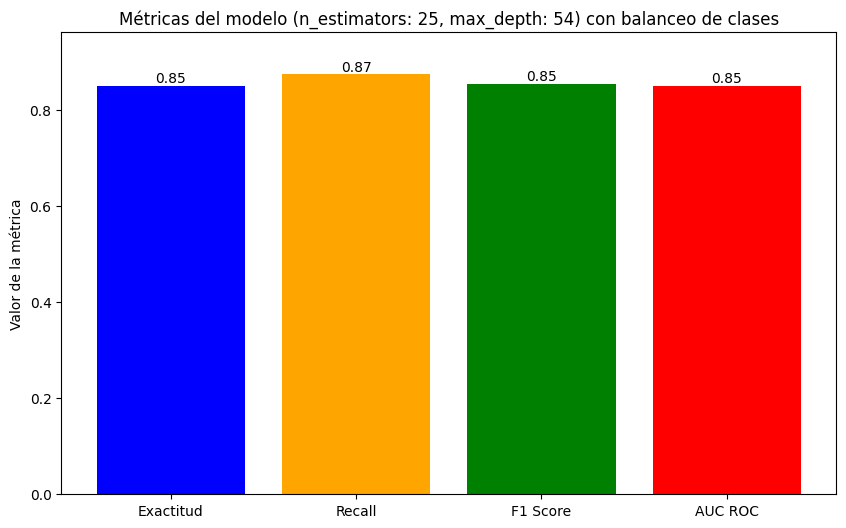

In [44]:

# Asegúrate de tener definidos features_train_res, target_train_res, features_valid_res y target_valid_res

# Modelo ajustado con valores ideales
n = 25
d = 54
model_2 = RandomForestClassifier(random_state=42, n_estimators=n, max_depth=d)
model_2.fit(features_train_res, target_train_res)
predicted_res = model_2.predict(features_valid_res)

# Calcular las métricas
acc = accuracy_score(target_valid_res, predicted_res)
rec = recall_score(target_valid_res, predicted_res)
f1 = f1_score(target_valid_res, predicted_res)
auc = roc_auc_score(target_valid_res, predicted_res)

# Preparar los datos para la gráfica
metricas = {
    'Exactitud': acc,
    'Recall': rec,
    'F1 Score': f1,
    'AUC ROC': auc
}
nombres = list(metricas.keys())
valores = list(metricas.values())

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
barras = plt.bar(nombres, valores, color=['blue', 'orange', 'green', 'red'])

# Agregar el valor exacto de cada métrica encima de la barra correspondiente
for barra in barras:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, altura, f'{altura:.2f}', ha='center', va='bottom')

plt.title(f'Métricas del modelo (n_estimators: {n}, max_depth: {d}) con balanceo de clases')
plt.ylabel('Valor de la métrica')
plt.ylim(0, 1.1 * max(valores))  # Ajustar límite superior para dar espacio a las etiquetas
plt.show()


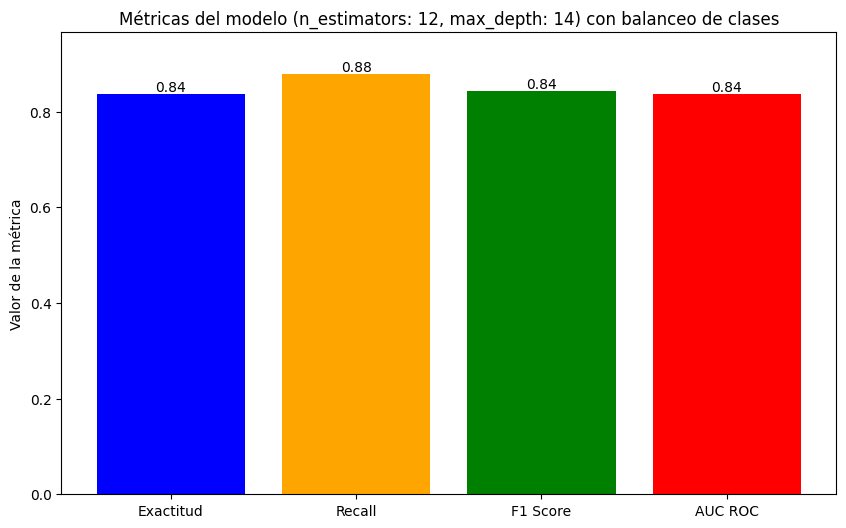

In [ ]:
# Modelo ajustado con valores practicos para presentar un modelo mas ligero pero eficiente
n = 12
d = 14
model_2 = RandomForestClassifier(random_state=42, n_estimators=n, max_depth=54)
model_2.fit(features_train_res,target_train_res)
predicted_res = model_2.predict(features_valid_res)

# Calcular las métricas
acc = accuracy_score(target_valid_res, predicted_res)
rec = recall_score(target_valid_res, predicted_res)
f1 = f1_score(target_valid_res, predicted_res)
auc = roc_auc_score(target_valid_res, predicted_res)

# Preparar los datos para la gráfica
metricas = {
    'Exactitud': acc,
    'Recall': rec,
    'F1 Score': f1,
    'AUC ROC': auc
}
nombres = list(metricas.keys())
valores = list(metricas.values())

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
barras = plt.bar(nombres, valores, color=['blue', 'orange', 'green', 'red'])

# Agregar el valor exacto de cada métrica encima de la barra correspondiente
for barra in barras:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, altura, f'{altura:.2f}', ha='center', va='bottom')

plt.title(f'Métricas del modelo (n_estimators: {n}, max_depth: {d}) con balanceo de clases')
plt.ylabel('Valor de la métrica')
plt.ylim(0, 1.1 * max(valores))  # Ajustar límite superior para dar espacio a las etiquetas
plt.show()

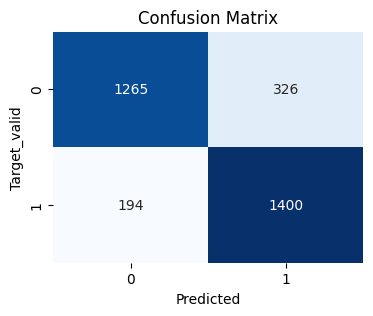

In [46]:
#Matriz de confusion con datos balanceados y modelo ajustado
cm = confusion_matrix(target_valid_res, predicted_res)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Target_valid')
plt.title('Confusion Matrix')
plt.show()

In [47]:
#Realizaremos una validacion cruzada con 5 folds

scores = cross_val_score(model_2, features_train_res, target_train_res, cv=5, scoring='accuracy')

# Imprimir los resultados
print(f"Exactitud en cada fold: {scores}")
print(f"Exactitud promedio: {np.mean(scores):.4f}")
print(f"Desviación estándar: {np.std(scores):.4f}")

Exactitud en cada fold: [0.81475667 0.81057038 0.80429095 0.79644165 0.8173731 ]
Exactitud promedio: 0.8087
Desviación estándar: 0.0076


#### Hallazgos

Configuración de Parámetros:

- n_estimators: Se fijó en 12, ya que a partir de ese valor las métricas se estabilizan y se evita incrementar el costo computacional de manera innecesaria.
- max_depth: Se estableció en 14, puesto que valores mayores no aportan mejoras significativas en los resultados, lo que permite optimizar el rendimiento sin sobrecargar el cómputo.

Rendimiento del Modelo con los Parámetros Configurados:

- Las métricas indican que el modelo tiene un desempeño adecuado, destacándose especialmente el F1_score y el recall.
- La matriz de confusión revela una alta cantidad de verdaderos positivos y verdaderos negativos, mientras que los falsos positivos y falsos negativos son mínimos.
- Exactitud (Accuracy): El modelo identifica correctamente el 84% de los casos positivos, lo cual es un indicador sólido.
- Recall (Sensibilidad): Con un 88% de verdaderos positivos correctamente identificados, el modelo demuestra una alta capacidad para detectar la clase positiva.
- F1_score: Con un valor del 84%, se confirma la robustez del modelo al equilibrar precisión y recall.
- AUC ROC: Un 84% en esta métrica indica que el modelo tiene un rendimiento significativamente superior al de un clasificador aleatorio.
- La validación cruzada refuerza la consistencia del modelo, mostrando una exactitud del 80% y una desviación estándar de 0.0076, lo que sugiere estabilidad en diferentes particiones de los datos.

#### Conclusión:

Los resultados demuestran que trabajar con clases balanceadas ofrece mejoras sustanciales en la exactitud y sensibilidad del modelo en comparación con el manejo de clases desbalanceadas.
Se recomienda implementar técnicas de balanceo de clases para asegurar una mayor generalización, robustez y consistencia en el rendimiento del modelo.
